# XGBoost Model for Prediciton of Sleep and Awake States

In [1]:
# Import needed libraries and packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

import random

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

RSEED=42


### Getting the Data into Dataframe

In [2]:
# Define the directory containing the files
data_directory = '../data/file_per_night'

If you already run the following cells and have the files 'train_data.parquet' and 'test_data.parque' in the 'data/file_per_night' directory, you can skip the following cells and continue with importing those two files into new dataframes.

In [ ]:
# Get a list of all files in the directory
file_paths = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, file))]

# Concatenate all dataframes into a single dataframe
dataframes = [pd.read_parquet(file) for file in file_paths]
full_dataframe = pd.concat(dataframes, ignore_index=True)

To have only two classes, we set the event 'onset' to 'awake' and 'wakeup' to 'sleep'

In [81]:
full_dataframe['event'].unique()

array(['awake', 'onset', 'sleep', 'wakeup'], dtype=object)

In [82]:
for i in full_dataframe.index:
    if full_dataframe['event'][i] == 'onset':
        full_dataframe['event'][i] = 'awake'
    elif full_dataframe['event'][i] == 'wakeup':
        full_dataframe['event'][i] = 'sleep'
    else:
        continue

full_dataframe['event'].unique()

array(['awake', 'sleep'], dtype=object)

### Remove Nas

In [ ]:
full_dataframe.isna().sum()

In [84]:
# remove Nas
full_dataframe.drop('night', axis = 1, inplace =True)
full_dataframe.dropna(inplace=True)

In [ ]:
full_dataframe.isna().sum()

### Train / Test Split

Next, we perform the regular train-test-split for training and evaluation of the model as usual:

In [86]:
# Split the data into train and test sets with stratification
train_data, test_data = train_test_split(full_dataframe, test_size=0.25, stratify=full_dataframe['event'], random_state=RSEED)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

Safe the train and test sets for later:

In [87]:
train_data.to_parquet(os.path.join(data_directory, "train_data.parquet"))
test_data.to_parquet(os.path.join(data_directory, "test_data.parquet"))

In [5]:
# use this to read the train and test set, if they were already created
train_data = pd.read_parquet(os.path.join(data_directory, "train_data.parquet"))
test_data = pd.read_parquet(os.path.join(data_directory, "test_data.parquet"))

In [6]:
train_data.head()

,anglez,enmo,step,anglez_std,enmo_std,series_id,slope_enmo,slope_anglez,anglez_outside_45_counter,enmo_over_008_counter,...,enmo_10min_std,enmo_10min_mean_shifted,enmo_10min_std_shifted,event,minutes_since_onset,year,month,day,hour,minute
0,-14.223984,0.003942,55889.5,17.420665,0.004248,db75092f0530,-0.001044,-2.988206,0,3,...,0.002640,0.008947,0.017574,awake,0.0,2018.0,6.0,10.0,18.0,22.0
1,-80.924500,0.000000,267617.5,0.000000,0.000000,8b159a98f485,0.000000,0.000000,12,0,...,0.000000,0.000000,0.000000,sleep,34.0,2019.0,6.0,12.0,21.0,56.0
2,28.887924,0.327517,350465.5,12.936250,0.190786,1716cd4163b2,-0.010472,0.678289,1,12,...,0.104317,0.372927,0.172498,awake,0.0,2019.0,5.0,23.0,19.0,15.0
3,12.347626,0.026342,62741.5,8.652647,0.016646,7504165f497d,-0.000198,0.904907,0,12,...,0.011654,0.021507,0.005416,awake,645.0,2017.0,9.0,25.0,7.0,38.0
4,-30.174082,0.024250,107537.5,1.352014,0.004262,8a22387617c3,-0.000633,0.212910,0,12,...,0.004228,0.027748,0.004891,awake,0.0,2018.0,8.0,19.0,21.0,36.0


### Preprocessing

In [7]:
# Extract features and target variable from the data
X_train = train_data.drop(['event', 'series_id', 'step'], axis=1).reset_index(drop=True)
y_train = train_data['event'].reset_index(drop=True)

X_test = test_data.drop(['event', "series_id", "step"], axis=1).reset_index(drop=True)
y_test = test_data['event'].reset_index(drop=True)

Oversampling

In [8]:
# For oversampling (because we have more sleep than awake states), we apply SMOTE
smote = SMOTE(random_state=RSEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train= X_train_smote
y_train = y_train_smote

If you want to reuse the 'smoted' data sets again (also for other models), you could now save it and afterwards only need to reload them.

In [ ]:
# Safe the oversampled train data into PARQUET and CSV files respectively
X_train.to_parquet(os.path.join(data_directory, "X_train_smote.parquet"))
y_train.to_csv(os.path.join(data_directory, "y_train_smote.csv"))

In [30]:
# Use this to reload the oversampled train data
X_train = pd.read_parquet(os.path.join(data_directory, "X_train_smote.parquet"))
y_train = pd.read_csv(os.path.join(data_directory, "y_train_smote.csv"))['event']

X_test = test_data.drop(['event', "series_id", "step"], axis=1).reset_index(drop=True)
y_test = test_data['event'].reset_index(drop=True)

In [8]:
# Preprossessing of features
scaler = MinMaxScaler()

# Scaling of features
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[5.01291104e-01, 3.10054302e-02, 1.17703925e-01, ...,
        5.00000000e-01, 3.91304348e-01, 2.20338983e-01],
       [3.09890226e-01, 7.49325600e-04, 4.59269376e-02, ...,
        9.66666667e-01, 2.17391304e-01, 7.79661017e-01],
       [3.82330718e-01, 9.59850402e-03, 4.65260328e-01, ...,
        4.66666667e-01, 9.13043478e-01, 6.94915254e-01],
       ...,
       [6.98523919e-01, 0.00000000e+00, 0.00000000e+00, ...,
        7.00000000e-01, 2.17391304e-01, 9.66101695e-01],
       [6.28358761e-02, 7.85007778e-04, 1.14381941e-01, ...,
        5.66666667e-01, 4.34782609e-02, 3.22033898e-01],
       [4.20580900e-01, 1.10269806e-02, 1.53085439e-01, ...,
        7.33333333e-01, 3.47826087e-01, 5.59322034e-01]])

In [13]:
# Preprocessing of target
def prepro(y):
    for i in range(len(y)):
        if y[i] == 'awake':
            y[i] = 1
        else: 
            y[i] = 0
    return y

In [34]:
y_train = prepro(y_train)
y_test = prepro(y_test)

In [35]:
y_train

0          1
1          0
2          1
3          1
4          1
          ..
3729771    1
3729772    1
3729773    1
3729774    1
3729775    1
Name: event, Length: 3729776, dtype: object

## Setting up and training of the model

Model type: XGBoost

In [36]:
# Initialize the Classifier
model = xgb.XGBClassifier(tree_method="hist")

In [37]:
# Train the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
# Make predictions on the test data
y_pred = model.predict(X_test)

Evaluation of the model performance:

In [39]:
accuracy = accuracy_score(list(y_test), list(y_pred))
precision = precision_score(list(y_test), list(y_pred), average='weighted')
recall = recall_score(list(y_test), list(y_pred), average='weighted')
f1 = f1_score(list(y_test), list(y_pred), average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 97.66%
Precision on test data: 97.66%
Recall on test data: 97.66%
F1 Score on test data: 97.66%


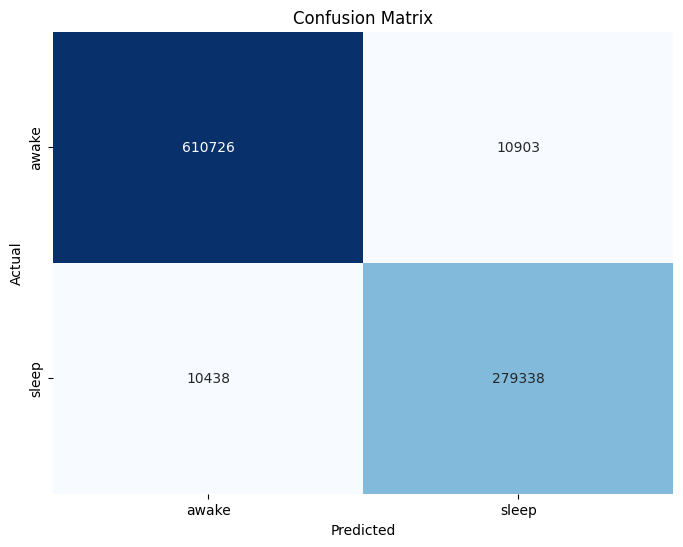

In [41]:
# Compute confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.xticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.ylabel('Actual')
plt.yticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.title('Confusion Matrix')
plt.show()

## Grid Search

To find a better performing model, we perform a grid search testing different parameters:

In [113]:
# Define the parameter grid to search
param_grid = {
    'tree_method': ['hist'],
    'verbosity': [2],
    'n_estimators': [7, 10],
    'max_depth': [5, 10, 20],
}

# Initialize the Decision Tree Classifier
modelCV = xgb.XGBClassifier(tree_method="hist")

In [ ]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(modelCV, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [112]:
# Print the best parameters and corresponding accuracy
best_params = grid_search.best_params_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 5, 'n_estimators': 2, 'tree_method': 'hist', 'verbosity': 2}


In [105]:
best_model = xgb.XGBClassifier(max_depth = 5, n_estimators = 5)

In [106]:
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [107]:
y_pred_best = best_model.predict(X_test)

In [108]:
accuracy = accuracy_score(list(y_test), list(y_pred_best))
precision = precision_score(list(y_test), list(y_pred_best), average='weighted')
recall = recall_score(list(y_test), list(y_pred_best), average='weighted')
f1 = f1_score(list(y_test), list(y_pred_best), average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 87.65%
Precision on test data: 88.51%
Recall on test data: 87.65%
F1 Score on test data: 87.86%


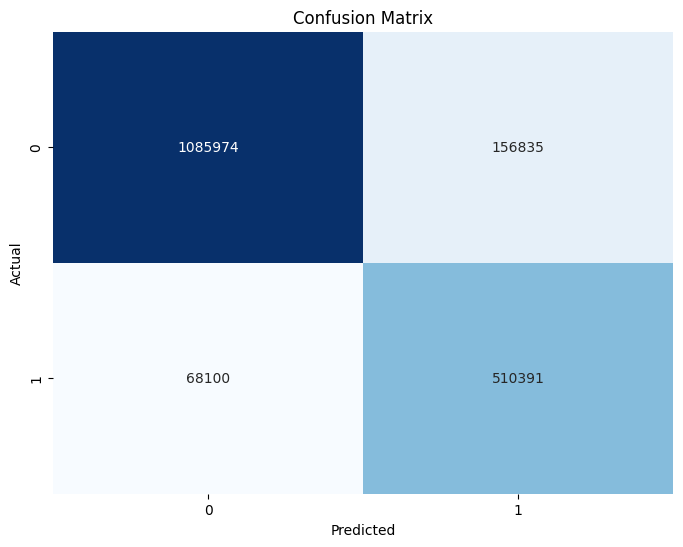

In [109]:
# Compute confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred_best))

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()